<a href="https://colab.research.google.com/github/Anshu00027/SAE-for-PINNs/blob/main/SAE-for-Taylor-Green-Vortex-PINNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

activations_array = np.load("/content/drive/MyDrive/SAE_project/last_hidden_activations.npy")
print(activations_array.shape)

# Min-Max normalization
min_vals = activations_array.min(axis=0)
max_vals = activations_array.max(axis=0)

activations_normalized = (activations_array - min_vals) / (max_vals - min_vals)

print("Normalized range:", activations_normalized.min(), activations_normalized.max())

(3475, 25)
Normalized range: 0.0 1.0


 We are loading the data from a trained PINNs model with 2 hidden layers having 25 neurosn each(architecture [3, 25, 25, 3]), solving Taylor Vortex Green problem, considering the activations of the last hidden layer (the second hidden layer) which contains 25 neurons
 These activations are collected for all training points(3475). so the shape should be (3475,25)

we are taking activations of neurons in the 2nd hidden layer of the PINNs network for each of its training data points (3,475 points) in the domain where the PDE is solved.  

So our complete data looks like:  

$$
[
I_1 = [AN1S_1, AN2S_1, AN3S_1, \dots, AN25S_1]
$$
$$
I_2 = [AN1S_2, AN2S_2, AN3S_2, \dots, AN25S_2]
$$
$$
\vdots
$$
$$
I_{3475} = [AN1S_{3475}, AN2S_{3475}, AN3S_{3475}, \dots, AN25S_{3475}]]
$$

where $I_k$ represents the activation vector corresponding to the $k^{th}$ training point of the PDE domain, and each element $ANjS_k$ denotes the activation value of the $j^{th}$ neuron for the $k^{th}$ sample.  

Collectively, these activation vectors form our requird dataset.

In other words, the SAE takes these activation vectors as input:
$$
I_k = [AN1S_k, AN2S_k, \dots, AN25S_k]
$$
and learns a latent representation of them of dimension `h_dim` through its encoder, while the decoder attempts to reconstruct the original activations:
$$
I_k \longrightarrow \text{Encoder} \longrightarrow h_{dim} \longrightarrow \text{Decoder} \longrightarrow \hat{I}_k
$$
where $h_k$ is the latent representation, and $\hat{I}_k$ is the reconstructed activation vector.


The loss in the sparse autoencoder consists of two parts: **reconstruction loss** and **sparsity penalty**.

1. **Reconstruction loss**:
$$
\text{MSE Loss} = \frac{1}{N} \sum_{n=1}^{3475} (I_n - \hat{I_n})^2
$$

2. **Sparsity penalty**:

For each hidden neuron, the average activation across a mini-batch os size m is
$$
\hat{\rho_j} = \frac{1}{m} \sum_{i=1}^{m} h_j^{(i)}
$$
 where $h_j$ is activation of that neuron for $j^{th}$ sample

The KL divergence between the target sparsity $\rho$ and the actual average activation $\hat{\rho_j}$ is
$$
\text{KL Divergence} = \rho \log \frac{\rho}{\hat{\rho_j}} + (1-\rho) \log \frac{1-\rho}{1-\hat{\rho_j}}
$$
The KL-divergence-based sparsity penalty is applied to the encoded activations to encourage most hidden neurons to remain inactive for each input. It measures the difference between the desired average activation (sparsity_target) and the actual average activation of each hidden neuron.

The total loss used for training the SAE is
$$
\text{Loss} = \text{MSE Loss} + \lambda \sum_{i=1}^{(h_{dim})} \text{KL Divergence}_i
$$
Here, $\lambda$ is a weighting factor(`sparsity_lamda`) that controls how strongly the sparsity constraint influences the total loss
This ensures the model reconstructs inputs accurately while maintaining sparsity in the hidden layer.



Normalization rescales neuron activations to a common range, making them easier to visualize, compare, and analyze.

# How this Sparse Autoencoder Trains

**Steps**
1. **Initialize the SAE model**  
   - Encoder: maping inputs to latent dimension(`h_{dim}`) using Sigmoid activation  
   - Decoder: reconstruct inputs from latent space using Tanh activation  
   - Apply Xavier initialization to the weights and initialize biases to zero for better convergence
   - Set sparsity parameters (`target_sparsity` and `sparsity_lambda`) to encourage most hidden neurons to remain inactive  

2. **Set up the optimizer** (Adam) with the chosen learning rate  

3. **Training Loop:**  
   - Repeat for `epoch = 1` to `n_epochs`:  
     1. Initialize `total_loss = 0` for  epoch  
     2. Shuffle dataset and split into mini-batches of size `batch_size`, iterate over all mini-batches in the dataset (ensures one epoch = full dataset seen once):  
        - for mini-batch form data
          - Clear previous gradients (`zero_grad`)  
          - **Forward pass:** encode inputs → latent representation → decode to reconstructed inputs  
          - **Compute loss:**  
            - Reconstruction error
            - Sparsity penalty
            - loss = reconstruction + sparsity penalty  
          - **Backward pass:** compute gradients of loss  
          - **Update weights** using the optimizer    
     3. **End of epoch:** all mini-batches processed

5. **Output:**  
   - Trained SAE model  


In [4]:
hidden_tensor = torch.tensor(activations_normalized, dtype=torch.float32)

print(hidden_tensor.shape)

torch.Size([3475, 25])


To improve training efficiency, we divide the data into mini-batches of 139 samples, allowing the model to iteratively update weights over multiple batches per epoch with shuffuling

Xavier initialization is used to initialize the weights, ensuring a stable start for training.

In [5]:

# Dataset (input,output)
dataset = TensorDataset(hidden_tensor, hidden_tensor)
dataloader = DataLoader(dataset, batch_size=139, shuffle=True)
# Here, we use mini-batching to improve training efficiency. Instead of processing all 3,475 activation samples at once in a single epoch, the data is divided into smaller batches of 139 samples each. The model iteratively trains on these mini-batches, completing one full pass (epoch) after all batches are processed.


# Sparse Autoencoder
class SparseAutoencoder(nn.Module):
    def __init__(self, in_dims, h_dims, sparsity_lambda, sparsity_target,xavier_norm_init=True):
        super().__init__()

        # The sparsity_target defines the desired average activation level of the hidden neurons encouraging most neurons to remain inactive for a given input.
        # The sparsity_lambda determines how strongly this sparsity penalty influences the total loss during training.

        self.xavier_norm_init = xavier_norm_init
       # The encoder consists of a fully connected layer that maps the input features to a hidden space (h_dims),by a Sigmoid activation function.
        self.encoder = nn.Sequential(
            nn.Linear(in_dims, h_dims),
            nn.Sigmoid() )

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.encoder[0].weight)
            nn.init.constant_(self.encoder[0].bias, 0)

        # The decoder reconstructs the original input from the compressed hidden representation.
        self.decoder = nn.Sequential(
            nn.Linear(h_dims, in_dims),
            nn.Tanh())

        if self.xavier_norm_init:
            nn.init.xavier_uniform_(self.decoder[0].weight)
            nn.init.constant_(self.decoder[0].bias, 0)

        self.sparsity_lambda = sparsity_lambda
        self.sparsity_target = sparsity_target

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

    # This function computes the KL sparsity penalty, which encourages the hidden layer activations to remain close to a target sparsity level. This sparsity penalty is applied on the encoded activations
    def sparsity_penalty(self, encoded):
        rho_hat = torch.mean(encoded, dim=0)
        rho = self.sparsity_target
        epsilon = 1e-8
        rho_hat = torch.clamp(rho_hat, min=epsilon, max=1-epsilon)
        kl_div = rho * torch.log(rho / rho_hat) + (1-rho) * torch.log((1-rho)/(1-rho_hat))
        return self.sparsity_lambda * torch.sum(kl_div)

    def loss_function(self, decoded, x, encoded):
        mse_loss = nn.functional.mse_loss(decoded, x)
        return mse_loss + self.sparsity_penalty(encoded)



During training, the full dataset of neuron activations is divided into **mini-batches**. Each mini-batch contains a subset of the total samples (e.g., 139 samples per batch in our case), which is fed into the sparse autoencoder at a time. This approach allows the model to **update its weights iteratively** after processing each batch rather than waiting to process the entire dataset.

Using mini-batches improves **training efficiency**, reduces memory usage, and can help the model converge faster. In the code, the `DataLoader` automatically selects these mini-batches in a **random order for each epoch** if `shuffle=True`, ensuring that the model sees different combinations of samples over training epochs.


In [18]:
# Train SAE for different latent dimensions

def train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
              sparsity_lambda, lr, n_epochs, device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    in_dim = hidden_tensor.shape[1]
    sae = SparseAutoencoder(in_dim, h_dim, sparsity_lambda, sparsity_target).to(device)
    optimizer = torch.optim.Adam(sae.parameters(), lr=lr)

    print(f"\n>>> Training SAE | h_dim={h_dim}, sparsity_target={sparsity_target}")
    for epoch in range(n_epochs):
        total_loss = 0
        for batch_x, _ in dataloader:
            batch_x = batch_x.to(device)
            optimizer.zero_grad()
            encoded, decoded = sae(batch_x)
            loss = sae.loss_function(decoded, batch_x, encoded)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if epoch%200 == 0:
              print(f"Epoch {epoch}/{n_epochs} - Loss: {total_loss/len(dataloader):.9f}")

    final_loss = total_loss / len(dataloader)
    print(f" Done: h_dim={h_dim}, sparsity_target={sparsity_target}, Final Loss={final_loss:.9f}\n")
    return final_loss, sae


# Experiment configurations


h_dims_list = [60,80,100,120]      # hidden layer sizes
sparsity_targets = [0.01,0.04,0.08,0.12]   # sparsity targets
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

results = {}
best_loss = float('inf')
best_config = None
best_model = None

# Train models & track best configuration
for h_dim in h_dims_list:
    losses = []
    for sparsity_target in sparsity_targets:
        final_loss, sae_model = train_sae(hidden_tensor, dataloader, h_dim, sparsity_target,
                                          sparsity_lambda=2e-4, lr=1e-3, n_epochs=1000, device=device)
        losses.append(final_loss)

        # Track the best model
        if final_loss < best_loss:
            best_loss = final_loss
            best_config = (h_dim, sparsity_target)
            best_model = sae_model

    results[h_dim] = losses

print(f"\n Best SAE configuration: h_dim={best_config[0]}, sparsity_target={best_config[1]}, loss={best_loss:.9f}")


>>> Training SAE | h_dim=60, sparsity_target=0.01
Epoch 0/1000 - Loss: 0.155606516
Epoch 200/1000 - Loss: 0.001272614
Epoch 400/1000 - Loss: 0.000311890
Epoch 600/1000 - Loss: 0.000104540
Epoch 800/1000 - Loss: 0.000042306
 Done: h_dim=60, sparsity_target=0.01, Final Loss=0.000022639


>>> Training SAE | h_dim=60, sparsity_target=0.04
Epoch 0/1000 - Loss: 0.445333828
Epoch 200/1000 - Loss: 0.001346139
Epoch 400/1000 - Loss: 0.000214733
Epoch 600/1000 - Loss: 0.000046398
Epoch 800/1000 - Loss: 0.000021147
 Done: h_dim=60, sparsity_target=0.04, Final Loss=0.000015618


>>> Training SAE | h_dim=60, sparsity_target=0.08
Epoch 0/1000 - Loss: 0.330992174
Epoch 200/1000 - Loss: 0.000879635
Epoch 400/1000 - Loss: 0.000105750
Epoch 600/1000 - Loss: 0.000032880
Epoch 800/1000 - Loss: 0.000022086
 Done: h_dim=60, sparsity_target=0.08, Final Loss=0.000017522


>>> Training SAE | h_dim=60, sparsity_target=0.12
Epoch 0/1000 - Loss: 0.272116098
Epoch 200/1000 - Loss: 0.000627798
Epoch 400/1000 - Los

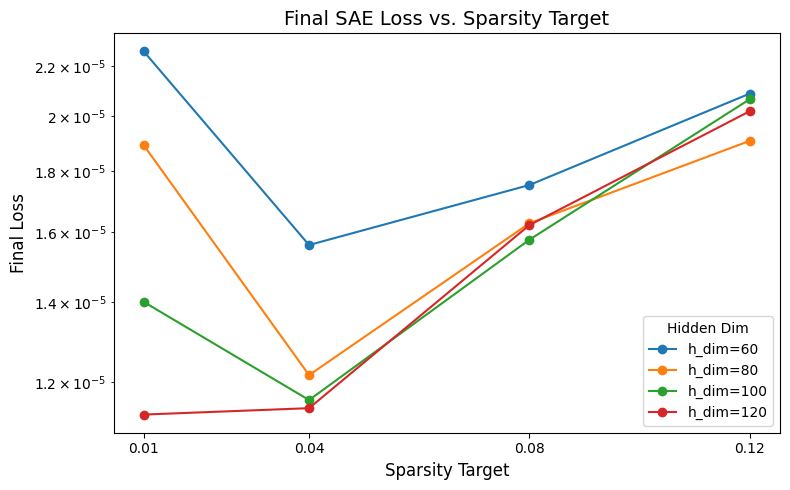

Saved mini-batch encoded activations: (139, 120)
Saved SAE encoded features shape: (3475, 120)


In [19]:
plt.figure(figsize=(8, 5))
for h_dim, losses in results.items():
    plt.plot(sparsity_targets, losses, marker='o', label=f'h_dim={h_dim}')
plt.xlabel('Sparsity Target', fontsize=12)
plt.ylabel('Final Loss', fontsize=12)
plt.title('Final SAE Loss vs. Sparsity Target', fontsize=14)
plt.legend(title='Hidden Dim')
plt.xticks(sparsity_targets)
plt.yscale('log')
plt.tight_layout()
plt.show()


# Save Encoded Outputs for Best Model
sae = best_model

# Save activation for any mini-batch
any_batch, _ = next(iter(dataloader))
with torch.no_grad():
    last_batch_encoded, _ = sae(any_batch.to(device))

any_batch_encoded = last_batch_encoded.cpu().numpy()
np.save("any_batch_encoded.npy", any_batch_encoded)
print("Saved mini-batch encoded activations:", any_batch_encoded.shape)

# Save full dataset encoded representation
with torch.no_grad():
    encoded, _ = sae(hidden_tensor.to(device))

encoded = encoded.cpu().numpy()
np.save("train_full_hidden_encoded.npy", encoded)
print("Saved SAE encoded features shape:", encoded.shape)

In [20]:
# Convert hidden activations to a DataFrame
activations = np.array(any_batch_encoded)  # (batch_size, num_neurons)
df = pd.DataFrame(activations, columns=[f"Neuron {i+1}" for i in range(activations.shape[1])])
# Show first 10 samples (rows) and first 10 neurons (columns) for readability
df_subset = df.iloc[:10, :10]

df_subset


,Neuron 1,Neuron 2,Neuron 3,Neuron 4,Neuron 5,Neuron 6,Neuron 7,Neuron 8,Neuron 9,Neuron 10
0,0.001168,0.001293,0.010290,0.001038,0.012330,0.025869,0.023441,0.007025,0.000291,0.026910
1,0.009441,0.015456,0.005747,0.005942,0.003997,0.009300,0.006611,0.004296,0.025187,0.003230
2,0.009151,0.007499,0.007163,0.000365,0.015336,0.006286,0.006999,0.028568,0.002126,0.018607
3,0.018077,0.014593,0.004961,0.009199,0.003608,0.001627,0.001001,0.009065,0.032479,0.003589
4,0.004192,0.004951,0.008638,0.000363,0.029484,0.005476,0.006619,0.012899,0.000795,0.027024
5,0.007459,0.006512,0.007097,0.000264,0.019077,0.004520,0.006016,0.022741,0.001567,0.022236
6,0.006411,0.005397,0.009119,0.000379,0.018703,0.007255,0.007399,0.018165,0.001275,0.023729
7,0.008152,0.003108,0.004433,0.042732,0.000909,0.000656,0.000416,0.001563,0.015847,0.001000
8,0.005936,0.024284,0.002841,0.000878,0.032266,0.004685,0.011181,0.041067,0.003702,0.006256
9,0.004235,0.001221,0.007753,0.004276,0.001479,0.001067,0.001886,0.001527,0.004475,0.007351


We have printed the activation values of neurons for each sample in the mini-batch.
    
Each row corresponds to the activation of neuron for a single sample from the mini-batch.

 As we can see, the tabular representation of activations lists raw numeric values for each neuron (columns) across samples in the mini-batch (rows).
 However, these values alone are not visually intuitive it is difficult to quickly identify which neurons/feature are more active, or how activation intensity varies across samples.




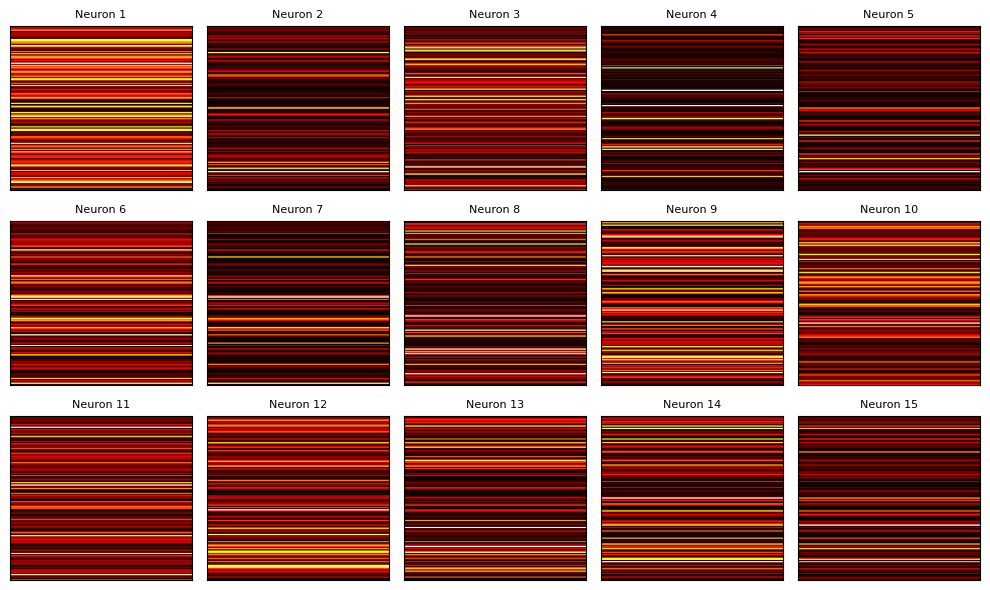

In [21]:
def plot_batch_activations(activations, num_neurons, neurons_per_row, save_path=None):
    num_rows = (num_neurons + neurons_per_row - 1) // neurons_per_row
    fig, axes = plt.subplots(num_rows, neurons_per_row, figsize=(neurons_per_row * 2, num_rows * 2))
    axes = axes.flatten()

    """
    Visualizes neuron activations across samples in any mini-batch.

    Each subplot represents one neuron. The vertical axis shows samples in the batch.
    Color intensity is the  activation magnitude.
    """


    for i in range(num_neurons):
        if i >= activations.shape[1]:
            break
        ax = axes[i]
        # Each neuron activation across the last batch samples

        ax.imshow(activations[:, i].reshape(-1, 1), aspect='auto', cmap='hot')
        ax.set_title(f'Neuron {i+1}', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])

    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=600, bbox_inches='tight')
    plt.show()


# Example call
plot_batch_activations(any_batch_encoded, num_neurons=15, neurons_per_row=5, save_path="pic.png")


To visualize the activations of the hidden neurons in a more detailed way, we use a grid of small heatmaps, with one subplot per neuron. In this layout, each subplot corresponds to a single neuron, and the vertical axis of the subplot represents the different input samples in the batch and the horizontal axis is just a single column representing that neuron. The color intensity within each subplot indicates the activation magnitude of that neuron for each sample: brighter colors correspond to stronger activations, while darker colors indicate weaker or no activation. This arrangement allows us to observe how each individual neuron responds across all samples in the mini-batch.

In [22]:
#  Load encoded activations
encoded_full = np.load("train_full_hidden_encoded.npy")
any_batch_encoded = np.load("any_batch_encoded.npy")

num_samples, num_neurons = encoded_full.shape
print(f"Full encoded shape: {encoded_full.shape}")

# Compute per-neuron threshold from mini batch
K = 10
thresholds = np.zeros(num_neurons)
for n in range(num_neurons):
    topk_values = np.sort(any_batch_encoded[:, n])[-K:]
    thresholds[n] = np.mean(topk_values)
print("Computed thresholds for all neurons.")

#  Check activation per neuron for each sample
active_matrix = encoded_full > thresholds

# Count how many samples activate each neuron
neuron_activity_counts = np.sum(active_matrix, axis=0)
# axis zero means For each neuron, count how many samples in which it is activated

#  Display top 10 most frequently active neurons
top_indices = np.argsort(-neuron_activity_counts)[:10]
print("\nTop 10 most active neurons:")
for idx in top_indices:
    print(f"Neuron {idx}: active in {neuron_activity_counts[idx]} / {num_samples} samples")


Full encoded shape: (3475, 120)
Computed thresholds for all neurons.

Top 10 most active neurons:
Neuron 116: active in 187 / 3475 samples
Neuron 11: active in 185 / 3475 samples
Neuron 36: active in 184 / 3475 samples
Neuron 4: active in 184 / 3475 samples
Neuron 13: active in 173 / 3475 samples
Neuron 63: active in 171 / 3475 samples
Neuron 17: active in 170 / 3475 samples
Neuron 75: active in 167 / 3475 samples
Neuron 65: active in 165 / 3475 samples
Neuron 82: active in 161 / 3475 samples


Now we want to check which sample input activates most of feature/neurosn in the best trained SAE

In [23]:
sample_activity_counts = np.sum(active_matrix, axis=1)
# axix 1 means count how many neurons are active for a sample

# Find the sample(s) that activated the most neurons
most_active_sample_idx = np.argmax(sample_activity_counts)
most_active_count = sample_activity_counts[most_active_sample_idx]

print(f"\nSample {most_active_sample_idx} activated {most_active_count} / {num_neurons} neurons (most active).")

# Display top most activating samples
top_samples = np.argsort(-sample_activity_counts)[:20]
print("\nTop 10 most neuron-activating samples:")
for idx in top_samples:
    print(f"Sample {idx}: activated {sample_activity_counts[idx]} features/neurons")



Sample 12 activated 23 / 120 neurons (most active).

Top 10 most neuron-activating samples:
Sample 12: activated 23 features/neurons
Sample 3378: activated 23 features/neurons
Sample 3429: activated 23 features/neurons
Sample 3428: activated 23 features/neurons
Sample 3379: activated 23 features/neurons
Sample 14: activated 22 features/neurons
Sample 13: activated 22 features/neurons
Sample 11: activated 21 features/neurons
Sample 3384: activated 21 features/neurons
Sample 29: activated 21 features/neurons
Sample 9: activated 20 features/neurons
Sample 44: activated 20 features/neurons
Sample 3377: activated 19 features/neurons
Sample 10: activated 19 features/neurons
Sample 237: activated 19 features/neurons
Sample 3427: activated 19 features/neurons
Sample 27: activated 19 features/neurons
Sample 28: activated 19 features/neurons
Sample 26: activated 19 features/neurons
Sample 8: activated 19 features/neurons
